include library 

In [393]:
import numpy as np
import control as ct
import pandas as pd
import matplotlib.pyplot as plt


NN = 50

Define Covariance Matrices Rww and Rvv for Kalman Filter

In [394]:
Rww = np.eye(3) * 10.0  # Amplified process noise covariance matrix (increased to 10.0)
Rvv = np.eye(1) * 5  # Amplified measurement noise covariance matrix

P0 = np.eye(3) * 20  # Initial error covariance matri

Noise Parameter

In [395]:
process_noise_cov = Rww  # Process noise covariance
measurement_noise_cov = Rvv  # Measurement noise covariance

x0 = np.array([[0], [0], [0]])        # Initial state
x_est0 = np.array([[0], [0], [0]])    # Initial state estimate
u0 = np.array([[0.15]])  # Initial control input u

System Matrices

In [396]:
b = 3.5088 * 10**-2
K = 0.0274 * 10**-2
j = 3.2284*10**-3
R = 4
L = 2.75*10**-3


A = np.array([[0, 1, 0],[0, -b/j, K/j],[0, -K/L, -R/L]])

B = np.array([[0],[0],[1/L]])

C = np.array([[1, 0, 0]])

D = np.array([[1]])

Define the sample time

In [397]:
Ts = 1

Create state-space model object

In [398]:
sys = ct.ss(A, B, C, D, Ts)

Display the state space model

In [399]:
print("Discrete State Space Model:")
print(sys)

print(C.shape)


print(x0)
x0.flatten()

Discrete State Space Model:
<LinearIOSystem>: sys[27]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']
States (3): ['x[0]', 'x[1]', 'x[2]']

A = [[ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
     [ 0.00000000e+00 -1.08685417e+01  8.48717631e-02]
     [ 0.00000000e+00 -9.96363636e-02 -1.45454545e+03]]

B = [[  0.        ]
     [  0.        ]
     [363.63636364]]

C = [[1. 0. 0.]]

D = [[1.]]

dt = 1

(1, 3)
[[0]
 [0]
 [0]]


array([0, 0, 0])

Kalman Filter (Linear Quadratic Estimator) Design

In [400]:
np.random.seed(42)  # bisa menggunakan angka berapapun sebagai seed

# # Noise parameters
# process_noise_cov = np.array([[0.1]])  # Kovarians noise proses (skalar)
# measurement_noise_cov = np.array([[3]])  # Kovarians noise pengukuran (skalar)

# Inisialisasi array untuk menyimpan hasil
x = np.zeros((A.shape[0], NN))
u = np.ones((1, NN)) * u0
ys = np.zeros((1, NN))

w = np.random.multivariate_normal(np.zeros(3), process_noise_cov, NN).T  # Process noise
v = np.random.multivariate_normal(np.zeros(1), measurement_noise_cov, NN).T  # Measurement noise

x0 = np.random.multivariate_normal(x0.flatten(), P0).reshape(-1, 1)

Open loop simulation

In [401]:
for k in range(0, NN):
    if k == 0:
        x[:, k] = (A @ x0 + B @ u0).flatten() + w[:, k]
    else:
        x[:, k] = A @ x[:, k-1] + B @ u[:, k-1] + w[:, k]
        ys[:, k-1] = C @ x[:, k-1] + D @ u[:, k-1] + v[:, k-1]

ys[:, NN-1] = C @ x[:, NN-1] + D @ u[:, NN-1] + v[:, NN-1]

x_simpan = x
print("Hasil ys:")
print(ys)

print(w.shape)

Hasil ys:
[[ 4.78877175e+000 -2.15424904e+001 -2.93739955e+002  8.66010624e+005
  -1.26435610e+009  1.83911458e+012 -2.67507630e+015  3.89102007e+018
  -5.65966553e+021  8.23224074e+024 -1.19741683e+028  1.74169720e+031
  -2.53337774e+034  3.68491306e+037 -5.35987351e+040  7.79617962e+043
  -1.13398976e+047  1.64943964e+050 -2.39918493e+053  3.48972351e+056
  -5.07596145e+059  7.38321663e+062 -1.07392241e+066  1.56206896e+069
  -2.27210030e+072  3.30487315e+075 -4.80708819e+078  6.99212825e+081
  -1.01703683e+085  1.47932630e+088 -2.15174733e+091  3.12981429e+094
  -4.55245713e+097  6.62175579e+100 -9.63164475e+103  1.40096650e+107
  -2.03776945e+110  2.96402828e+113 -4.31131385e+116  6.27100193e+119
  -9.12145732e+122  1.32675742e+126 -1.92982897e+129  2.80702395e+132
  -4.08294391e+135  5.93882748e+138 -8.63829448e+141  1.25647919e+145
  -1.82760609e+148  2.65833612e+151]]
(3, 50)


In [402]:
x_est_bar = np.zeros((A.shape[1], NN))
P_bar = np.zeros((A.shape[1], A.shape[1], NN))
K = np.zeros((A.shape[1], NN))
x_est = np.zeros((A.shape[1], NN))
Pklmn = np.zeros((A.shape[1], A.shape[1], NN))


print(P0.shape)
print(x_est_bar.shape)
print(P_bar.shape)
print(K.shape)
print(x_est.shape)
print(Pklmn.shape)

(3, 3)
(3, 50)
(3, 3, 50)
(3, 50)
(3, 50)
(3, 3, 50)


Algoritma Kalman Filter

In [403]:
for k in range(0, NN):
    if k == 0:
        # Prediction step
        x_est_bar[:, k] = (A @ x_est0 + B @ u0).flatten()
        P_bar[:, :, k] = A @ P0 @ A.T + Rww

        # Correction step
        K[:, k] = (P_bar[:, :, k] @ C.T @ np.linalg.inv(C @ P_bar[:, :, k] @ C.T + Rvv)).flatten()
        x_est[:, k] = (x_est_bar[:, k].reshape(A.shape[0], 1) + K[:, k].reshape(A.shape[0], 1) @
                       (ys[:, k] - C @ x_est_bar[:, k]).reshape(1, 1)).flatten()
        Pklmn[:, :, k] = np.linalg.inv(np.linalg.inv(P_bar[:, :, k]) + C.T @ np.linalg.inv(Rvv) @ C)

    else:
        # Prediction step
        x_est_bar[:, k] = (A @ x_est[:, k-1] + B @ u[:, k-1]).flatten()
        P_bar[:, :, k] = A @ Pklmn[:, :, k-1] @ A.T + Rww

        # Correction step
        K[:, k] = (P_bar[:, :, k] @ C.T @ np.linalg.inv(C @ P_bar[:, :, k] @ C.T + Rvv)).flatten()
        x_est[:, k] = (x_est_bar[:, k].reshape(A.shape[0], 1) + K[:, k].reshape(A.shape[0], 1) @
                       (ys[:, k] - C @ x_est_bar[:, k]).reshape(1, 1)).flatten()
        Pklmn[:, :, k] = np.linalg.inv(np.linalg.inv(P_bar[:, :, k]) + C.T @ np.linalg.inv(Rvv) @ C)



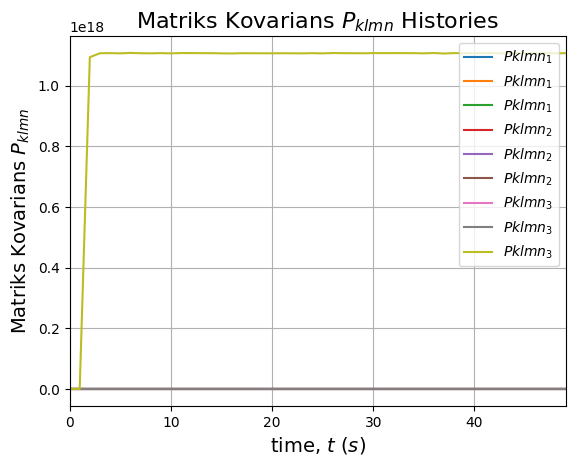

In [404]:
# Plotting P
t = np.arange(0, NN*Ts, Ts)
plt.figure()
for k in range(P_bar.shape[0]):         #in python, index from 0
    plt.plot(t, Pklmn[k, :].T, label=f'$Pklmn_{k+1}$')
plt.xlim(t[0], t[-1])
plt.xlabel('time, $t$ $(s)$', fontsize=14)
plt.ylabel('Matriks Kovarians $P_{klmn}$', fontsize=14)
plt.legend(loc='upper right')
plt.title('Matriks Kovarians $P_{klmn}$ Histories', fontsize=16)
plt.grid(True)
plt.show()

In [405]:
y0 = np.array([[0]])
ys = np.concatenate((y0, ys), axis=1)
x = np.concatenate((x0, x), axis=1)
x_est = np.concatenate((x_est0, x_est), axis=1)


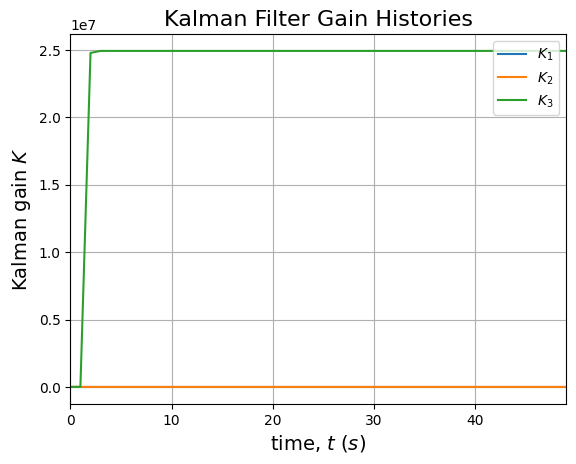

In [406]:
# Plotting
t = np.arange(0, NN*Ts, Ts)
plt.figure()
for k in range(K.shape[0]):         #in python, index from 0
    plt.plot(t, K[k, :], label=f'$K_{k+1}$')
plt.xlim(t[0], t[-1])
plt.xlabel('time, $t$ $(s)$', fontsize=14)
plt.ylabel('Kalman gain $K$', fontsize=14)
plt.legend(loc='upper right')
plt.title('Kalman Filter Gain Histories', fontsize=16)
plt.grid(True)
plt.show()

In [407]:
# print("Estimated states:")
# print(K.shape)
print("Steady-State Discrete Kalman Filter Gain:")
Kklmn = K[:,NN-1]
print(Kklmn.reshape(A.shape[1],1))

Steady-State Discrete Kalman Filter Gain:
[[ 9.99999999e-01]
 [-1.46532179e+03]
 [ 2.49266455e+07]]


Shape of t: (51,)
Shape of ys: (1, 51)
3 3 1


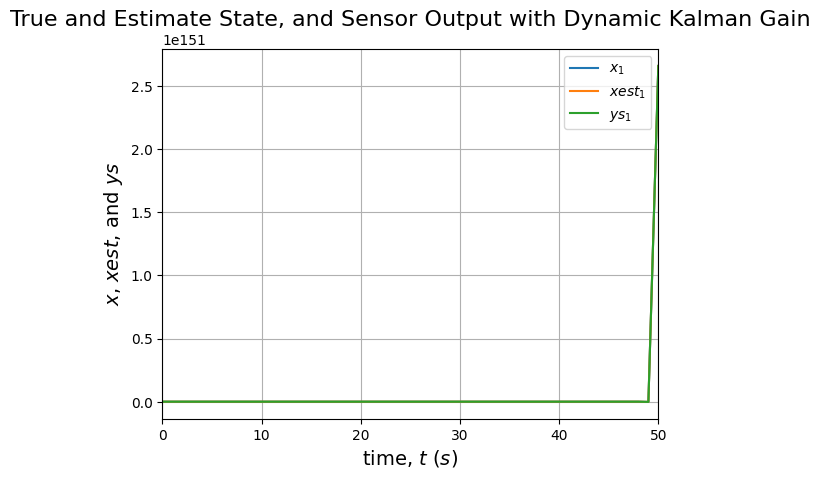

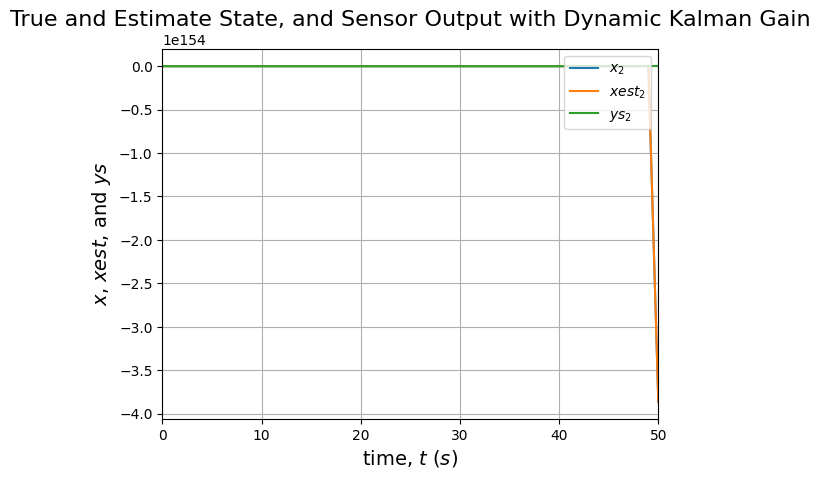

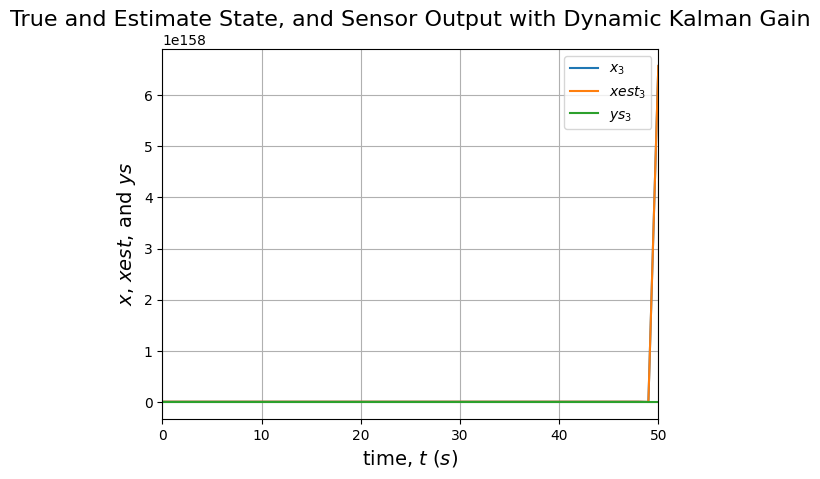

In [408]:
t = np.arange(0, NN*Ts+1, Ts)
print("Shape of t:", t.shape)
print("Shape of ys:", ys.shape)
print(len(x), len(x_est), len(ys))
    
for k in range(x.shape[0]):         #in python, index from 0
    plt.figure()
    plt.plot(t, x[k, :], label=f'$x_{k+1}$')
    plt.plot(t, x_est[k, :], label=f'$xest_{k+1}$')
    plt.plot(t, ys[0, :], label=f'$ys_{k+1}$')
    plt.xlim(t[0], t[-1])
    plt.xlabel('time, $t$ $(s)$', fontsize=14)
    plt.ylabel('$x$, $xest$, and $ys$', fontsize=14)
    plt.legend(loc='upper right')
    plt.title('True and Estimate State, and Sensor Output with Dynamic Kalman Gain', fontsize=16)
    plt.grid(True)
    plt.show()
    


In [409]:
# Inisialisasi array untuk menyimpan hasil
x_est_bar = np.zeros((A.shape[1], NN))
P_bar = np.zeros((A.shape[1], A.shape[1], NN))
K = np.zeros((A.shape[1], NN))
x_est = np.zeros((A.shape[1], NN))
Pklmn = np.zeros((A.shape[1], A.shape[1], NN))
print(Pklmn)

[[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

In [410]:
# Algoritma Kalman Filter
for k in range(0, NN):
    if k == 0:
        # for prediction
        x_est_bar[:, k] = (A@x_est0 + B@u0).flatten()
        # P_bar[:, :, k] = A@P0@A.T + Rww

        # for correction
        # K[:, k] = (P_bar[:, :, k]@C.T@np.linalg.inv(C@P_bar[:, :, k]@C.T + Rvv)).flatten()
        x_est[:, k] = (x_est_bar[:, k].reshape(A.shape[1],1) + Kklmn.reshape(A.shape[1],1)@(ys[:, k] - C@x_est_bar[:, k]).reshape(1,1)).flatten()
        # Pklmn[:, :, k] = (np.eye(A.shape[0]) - K[:, k].reshape(A.shape[1],1)@C)@P_bar[:, :, k]
    else:
        # for prediction
        x_est_bar[:, k] = (A@x_est[:, k-1] + B@u[:, k-1]).flatten()
        # P_bar[:, :, k] = A@Pklmn[:, :, k-1]@A.T + Rww

        # for correction
        # K[:, k] = (P_bar[:, :, k]@C.T@np.linalg.inv(C@P_bar[:, :, k]@C.T + Rvv)).flatten()
        x_est[:, k] = (x_est_bar[:, k].reshape(A.shape[1],1) + Kklmn.reshape(A.shape[1],1)@(ys[:, k] - C@x_est_bar[:, k]).reshape(1,1)).flatten()
        # Pklmn[:, :, k] = (np.eye(A.shape[0]) - K[:, k].reshape(A.shape[1],1)@C)@P_bar[:, :, k]


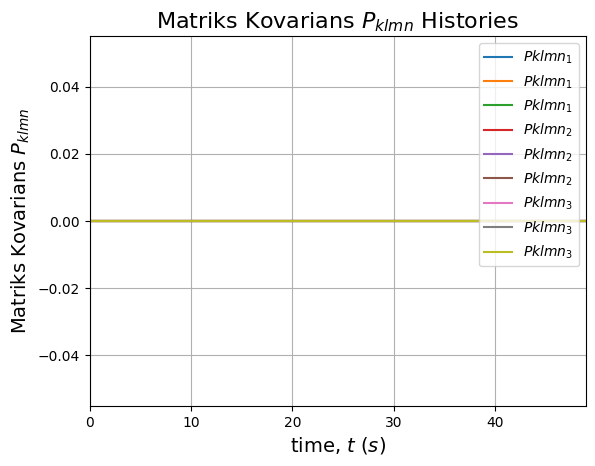

In [411]:
# Plotting P
t = np.arange(0, NN*Ts, Ts)
plt.figure()
for k in range(P_bar.shape[0]):         #in python, index from 0
    plt.plot(t, Pklmn[k, :].T, label=f'$Pklmn_{k+1}$')
plt.xlim(t[0], t[-1])
plt.xlabel('time, $t$ $(s)$', fontsize=14)
plt.ylabel('Matriks Kovarians $P_{klmn}$', fontsize=14)
plt.legend(loc='upper right')
plt.title('Matriks Kovarians $P_{klmn}$ Histories', fontsize=16)
plt.grid(True)
plt.show()

In [412]:
x = np.zeros((A.shape[1], NN))
x = x_simpan

x = np.concatenate((x0, x), axis=1)
x_est = np.concatenate((x_est0, x_est), axis=1)

print(x.shape)

print(x_est.shape)

print(Kklmn)


(3, 51)
(3, 51)
[ 9.99999999e-01 -1.46532179e+03  2.49266455e+07]
